XGBoost

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('credit_card.csv')

y = df['Class']
X = df.drop(['Class','Amount','Time'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

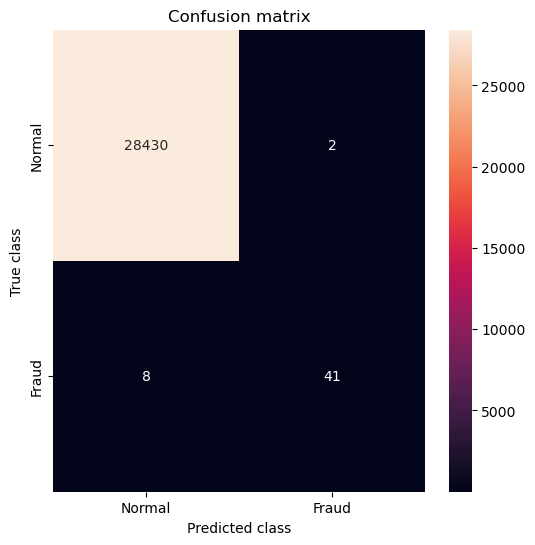

In [5]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Adjust weight

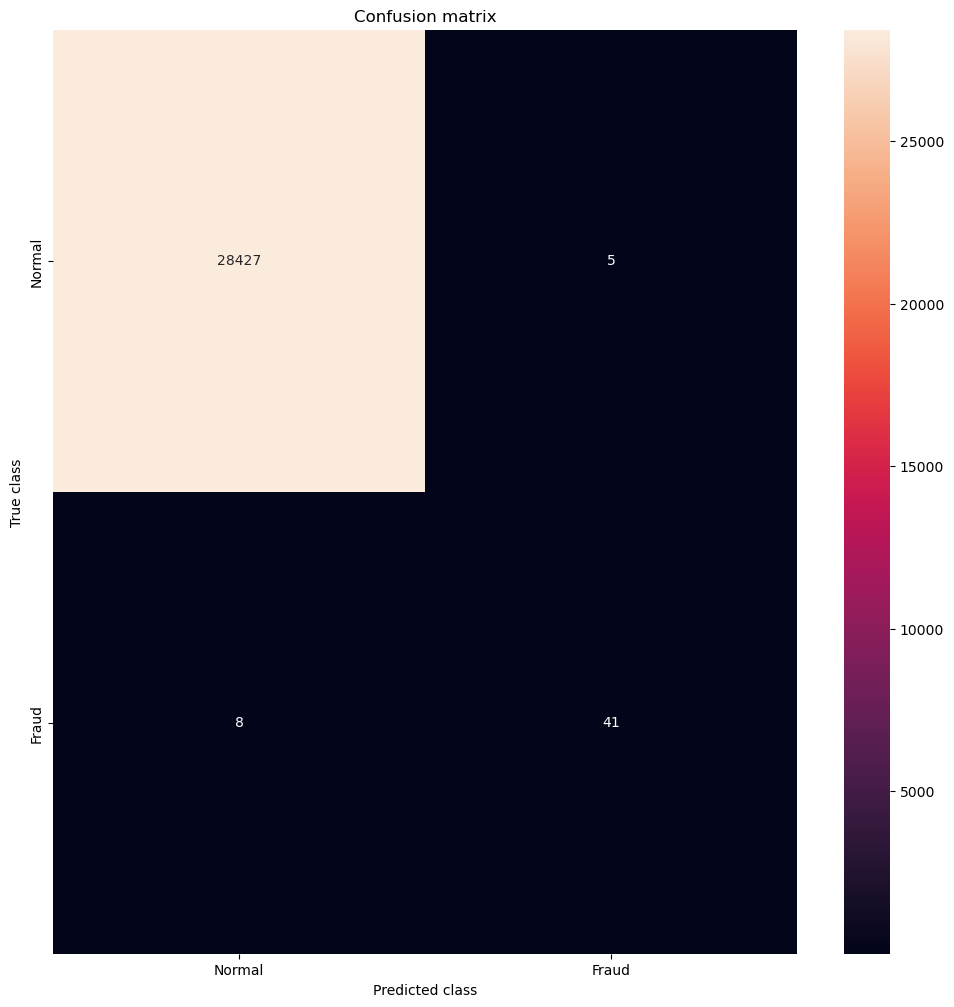

In [6]:
model = xgb.XGBClassifier(scale_pos_weight=100)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

LABELS = ["Normal", "Fraud"]

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

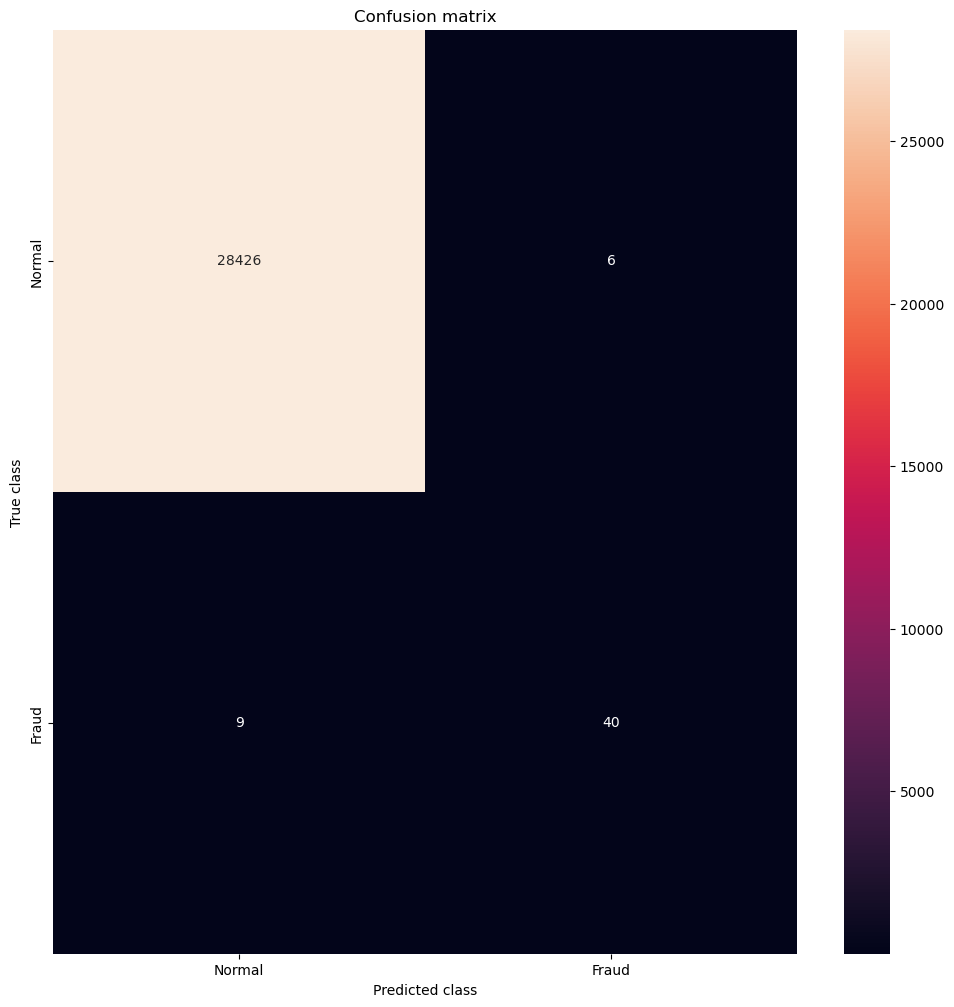

In [7]:
model = xgb.XGBClassifier(max_depth=5, scale_pos_weight=100) 
# max_depth specifies the maximum depth to which each tree will be built.
# reduces overfitting
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

LABELS = ["Normal", "Fraud"]
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [8]:
model.classes_

array([0, 1])

In [9]:
model.feature_importances_

array([0.01312514, 0.00784569, 0.0100591 , 0.05357756, 0.01087751,
       0.00794495, 0.01373471, 0.01787292, 0.00532201, 0.01796621,
       0.01067202, 0.03793157, 0.02628328, 0.5975068 , 0.01172574,
       0.00766153, 0.05387616, 0.00919916, 0.01226081, 0.01598488,
       0.00507836, 0.00916433, 0.01107373, 0.00602694, 0.00522209,
       0.01114778, 0.00378145, 0.00707763], dtype=float32)

In [10]:
cost_tn = 1
cost_fp = 10
cost_fn = 100
cost_tp = 1

In [11]:
total_cost_of_fraud_xgb = (conf_matrix[0][0] * cost_tn) + (conf_matrix[0][1] * cost_fp) + (conf_matrix[1][0] * cost_fn) + (conf_matrix[1][1] * cost_tp)
total_cost_of_fraud_xgb

29426

Accuracy Paradox

In [13]:
import numpy as np

np.zeros(len(y_test))

from sklearn.metrics import accuracy_score

y_pred_acc = np.zeros(len(y_test))
print('Accuracy Score:', round(accuracy_score(y_test, y_pred_acc), 5))

Accuracy Score: 0.99828


In [14]:
from sklearn.metrics import (classification_report, precision_score, recall_score,
                             average_precision_score, roc_auc_score,
                             f1_score, matthews_corrcoef)                        

In [15]:
# Precision is the proportion of correctly predicted fraudulent instances among all instances predicted as fraud
# TP / (TP + FP)
# TP = 40, FP = 6

precision_score(y_test, y_pred)

0.8695652173913043

In [16]:
# Recall is the proportion of the fraudulent instances that are successfully predicted
# TP / (TP + FN)
# TP = 40, FN = 9

recall_score(y_test, y_pred)

0.8163265306122449

In [17]:
# F1-score is the harmonic balance of precision and recall (can be weighted more towards P or R if need be)
# F = 2 * (Precision * Recall)/(Precision + Recall)
# F = 2 * (0.870 * 0.816)/(0.870 + 0.816)

f1_score(y_test, y_pred)

0.8421052631578947

In [18]:
# AUROC/AUC = Area under the Receiver Operating Characteristic curve
# plot the TPR (Recall, true positive rate) and FPR (false positive rate) at various classification thresholds
# FPR = FP / (FP + TN)
# Good measure of overall performance

roc_auc_score(y_test, y_pred)

0.9080577503933481

In [19]:
# AUPRC = Area under the Precision-Recall curve
# Better alternative to AUC as doesn't include TN which influences the scores significantly in highly imbalanced data
# calculates the area under the curve at various classification thresholds

average_precision_score(y_test, y_pred)

0.7101651571945705

In [20]:
# Classification report summarizes the classification metrics at the class and overall level

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.87      0.82      0.84        49

    accuracy                           1.00     28481
   macro avg       0.93      0.91      0.92     28481
weighted avg       1.00      1.00      1.00     28481



Threshold Optimization

In [22]:
# probability of being fraudulent
y_pred = model.predict_proba(X_test)[:,1]

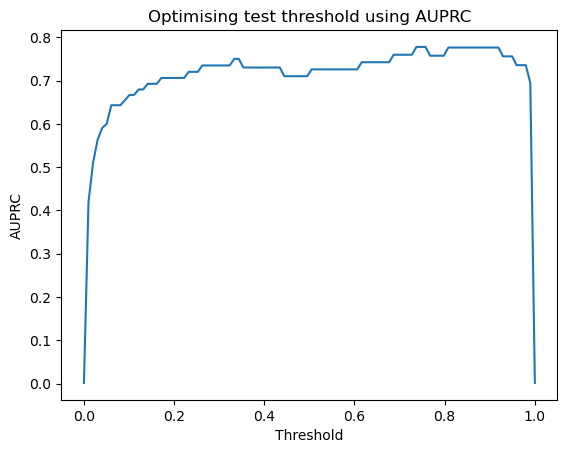

In [23]:
import numpy as np
from sklearn.metrics import average_precision_score

threshold_list = []
auprc_list = []
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    y_pred_thresh = [1 if e > threshold else 0 for e in y_pred]
    threshold_list.append(threshold)
    
    auprc_score = average_precision_score(y_test, y_pred_thresh)
    auprc_list.append(auprc_score)

# plot curve
threshold_df = pd.DataFrame(threshold_list, auprc_list).reset_index()
threshold_df.columns = ['AUPRC', 'Threshold']

plt.plot(threshold_df['Threshold'], threshold_df['AUPRC'])
plt.title("Optimising test threshold using AUPRC")
plt.xlabel('Threshold')
plt.ylabel('AUPRC')
plt.savefig('Optimising threshold using AUPRC');
plt.show()

In [24]:
threshold_df.sort_values(by='AUPRC', ascending=False)

,AUPRC,Threshold
75,0.777770,0.757576
73,0.777770,0.737374
74,0.777770,0.747475
87,0.776372,0.878788
80,0.776372,0.808081
...,...,...
3,0.563415,0.030303
2,0.510139,0.020202
1,0.419485,0.010101
0,0.001720,0.000000


In [25]:
threshold_df.loc[(threshold_df['AUPRC'] >= 0.77)]

,AUPRC,Threshold
73,0.777770,0.737374
74,0.777770,0.747475
75,0.777770,0.757576
80,0.776372,0.808081
81,0.776372,0.818182
82,0.776372,0.828283
83,0.776372,0.838384
84,0.776372,0.848485
85,0.776372,0.858586
86,0.776372,0.868687


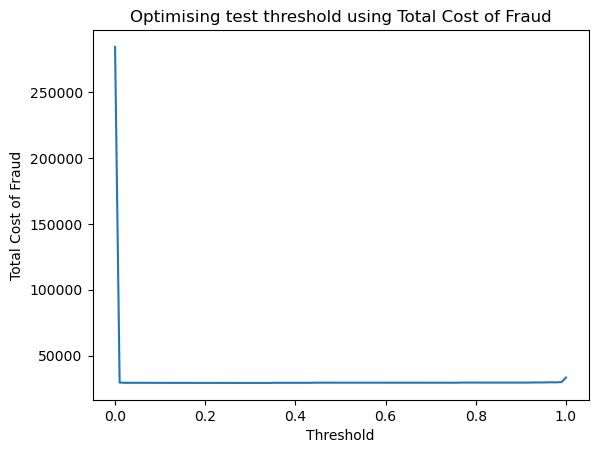

In [26]:
import numpy as np
from sklearn.metrics import average_precision_score

threshold_list = []
tcf_list = []
# hard coded random costs
cost_tn = 1
cost_fp = 10
cost_fn = 100
cost_tp = 1
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    y_pred_thresh = [1 if e > threshold else 0 for e in y_pred]
    threshold_list.append(threshold)

    conf_matrix_xgb = confusion_matrix(y_test, y_pred_thresh)
    tcf_score = (conf_matrix_xgb[0][0] * cost_tn) + (conf_matrix_xgb[0][1] * cost_fp) + (conf_matrix_xgb[1][0] * cost_fn) + (conf_matrix_xgb[1][1] * cost_tp)
    tcf_list.append(tcf_score)

# plot curve
threshold_df = pd.DataFrame(threshold_list, tcf_list).reset_index()
threshold_df.columns = ['TCF', 'Threshold']

plt.plot(threshold_df['Threshold'], threshold_df['TCF'])
plt.title("Optimising test threshold using Total Cost of Fraud")
plt.xlabel('Threshold')
plt.ylabel('Total Cost of Fraud')
plt.savefig('Optimising threshold using Total Cost of Fraud');
plt.show()

In [27]:
# if threshold = 0, then everything is fraud (lots of false positives which cost $10 each)
# if threshold = 1, then everything is non-fraudulent (quite a few missed cases of fraud which cost $100 each)
# optimal threshold for this model is around 50% (already well balanced)

threshold_df.sort_values(by='TCF', ascending=True)

,TCF,Threshold
34,29228,0.343434
33,29228,0.333333
32,29237,0.323232
31,29237,0.313131
30,29237,0.303030
...,...,...
96,29678,0.969697
97,29678,0.979798
98,29876,0.989899
99,33332,1.000000


In [28]:
error_df = pd.DataFrame(y_pred, y_test).reset_index()
error_df.columns = ['Target variable', 'Score']
error_df.to_csv('error_df.csv')